Philippe Joly 2025-05-25

# ALBATROS Data Overview

This notebook is an overview of the structure of the ALBATROS data and the associated [albatros_analysis](https://github.com/ALBATROS-Experiment/albatros_analysis) repository
<br> This notebook uses a 1 hour of data rechannelized ($\times64$) to a frequency resolution of ~1 kHz. 

In [27]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
from scipy import linalg
sys.path.append(os.path.expanduser('~'))

Telescope data fwom which the data used in this notebook stems from was recorded with:
- a 0-125 MHz frequency span;
- 2048 frequency channels; and
- a $250\times10^6$ samples/s samplig rate

## Data Structure 

In [5]:
with np.load("/project/s/sievers/mohanagr/xcorr_axion/xcorr_all_ant_4bit_1721361571_14336_64_15326_0_120.npz") as f:
    data = f['data']
    mask = f['mask']
    missing_fraction = f["missing_fraction"]
    chans = f['chans']

First analyze the name of the file: *xcorr_all_ant_4bit_1721361571_14336_64_15326_0_120.npz*

1. *4bit* : tells us that every values is strored as a 4bit complex number
2. *1721361571* : Subdirectory time stamp from wchich this exceprt of data was taken
3. *14336* : 'FFT' size (size of transform window) in terms of 1/(frquency resolution) s steps (Note that it is not actually a FFT)
3. *64* : factor by wich it was rechannelized from the storage frequency resolution of 61 kHz
4. *15326* : The number of time steps
5. *0_120* : Frequency span in MHz

In [8]:
print("Data Shape:", data.shape)
print("Mask Shape:", mask.shape)
print("Missing Fraction Shape:", missing_fraction.shape)
print("Channels Shape", chans.shape)

Data Shape: (2, 2, 7680, 15326)
Mask Shape: (2, 2, 7680, 15326)
Missing Fraction Shape: (1, 15326)
Channels Shape (7680,)


The mask is to account for values missing from the data acquisition. During data acquisition, missing measurements were recorded as zero values to conserve the time structure of the data. The mask allows the zero values to be omitted from analysis. The missing fraction array is the fraction of channels missing at a specific recording time. 

We can breakdown the shape of the data array: (2, 2, 7680, 15326)
1. (2, 2, x, x) : acccounts for the 4 polarization of the dual-polarization LWA antenna 
    1. (0, 0) : pol0 data auto-correlated with itself
    2. (1, 1) : pol1 data auto-correlated with itself
    3. (0, 1), (1, 0) : pol0 cross-correlated with pol1. Note that (0, 1) and (1, 0) are hermitian conjugate.
2. (x, x, 7680, x) : This is the number of frequency channels.
3. (x, x, x, 15326) : number of time steps

## Data Specifications 

In [53]:
df_record = 125e6/2048 # (Hz) frequency range / # of channels
df = df_record/64 # (Hz) / rechannelization factor
print(df_record*1e-3, "kHz Frequency resolution when recorded")
print(df*1e-3, "kHz Frequency resolution after x64 rechannelization")

61.03515625 kHz Frequency resolution when recorded
0.95367431640625 kHz Frequency resolution after x64 rechannelization


In [54]:
sr = 250e6 # sampling rate
recording_step_length = 1/sr # (s)
N = 14336 # samples/window
fft_window_length = 14336*recording_step_length # (s) 
print("Time step of recording:", recording_step_length*1e9, "ns")
print("Transform window length:", fft_window_length*1e6, "mu s")
print("Raw recording frequency:", 1/fft_window_length*1e-3, "kHz")

Time step of recording: 4.0 ns
Transform window length: 57.34400000000001 mu s
Raw recording frequency: 17.43861607142857 kHz


Notice that the raw frequency resolution ~17 kHz is better than the data frquency resolution. This is because the transform outputs were aggregates/averaged to get channels spaced ~61 kHz apart. 

In [58]:
total_time = 14436/df_record*15326 # (s)
print(total_time/(60**2), "hour of total obeservation time")

1.0069157478400002 hour of total obeservation time


##  Data Visualisation

In [67]:
spectra = np.ma.MaskedArray(data=data, mask=mask)
freqs = chans*df*1e-3 # (Hz)

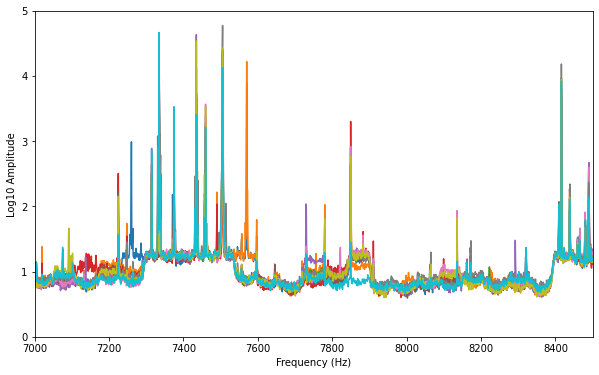

In [71]:
plt.figure(figsize=(10,6))
for i in range(10):    
    plt.plot(freqs, np.log10(np.abs(spectra[0,0,:,(i+1)*100])))
    
plt.xlim(7000, 8500)
plt.ylim(0,5)

plt.xlabel('Frequency (Hz)')   
plt.ylabel('Log10 Amplitude')

plt.show()

This plot illustrates data amplitude across frequencies at particular times.

/gpfs/fs1/home/s/sievers/philj0ly/Jupyter/lib64/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


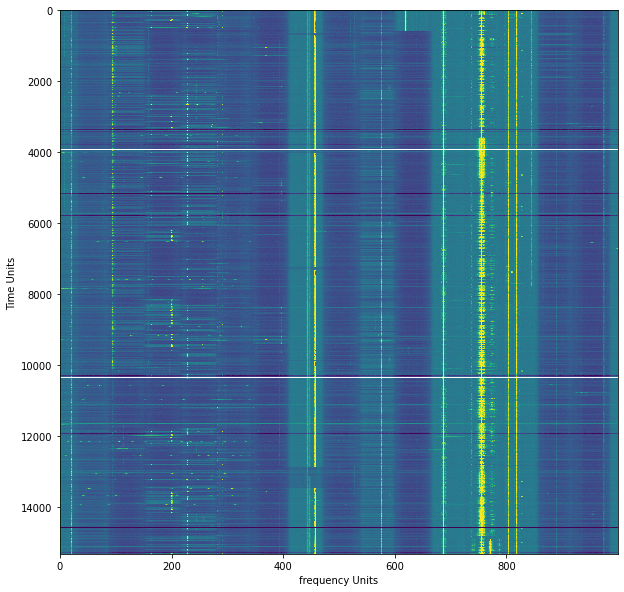

In [76]:
# Waterfall plot
plt.figure(figsize=(10,10))
plt.imshow(np.log10(np.abs(spectra[0, 0, 5000:6000, :].T)), aspect='auto', vmin=0, vmax=3, interpolation='none')
plt.ylabel("Time Units")
plt.xlabel("frequency Units")
plt.show()